# TSA: Explore

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import acquire_walkthrough
import prepare_walkthrough

In [2]:
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
plt.style.use('fivethirtyeight')

## Store Data

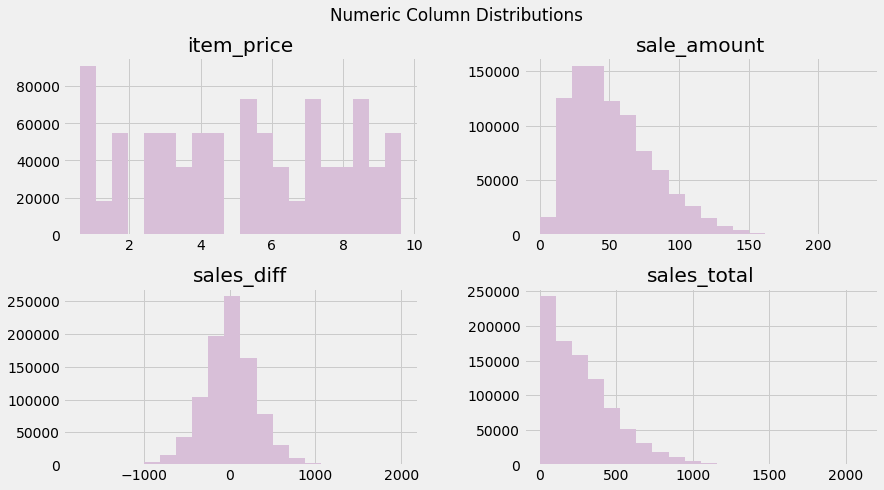

In [3]:
df = prepare_walkthrough.prepped_store_df()

> Split your data into train and test using the sklearn.model_selection.TimeSeriesSplit method.

We're going to use the last year as the test dataset

In [4]:
df.index.min(), df.index.max()

(Timestamp('2013-01-01 00:00:00+0000', tz='UTC'),
 Timestamp('2017-12-31 00:00:00+0000', tz='UTC'))

In [5]:
train = df[:'2016']
test = df['2017']

> Validate your splits by plotting X_train and y_train.

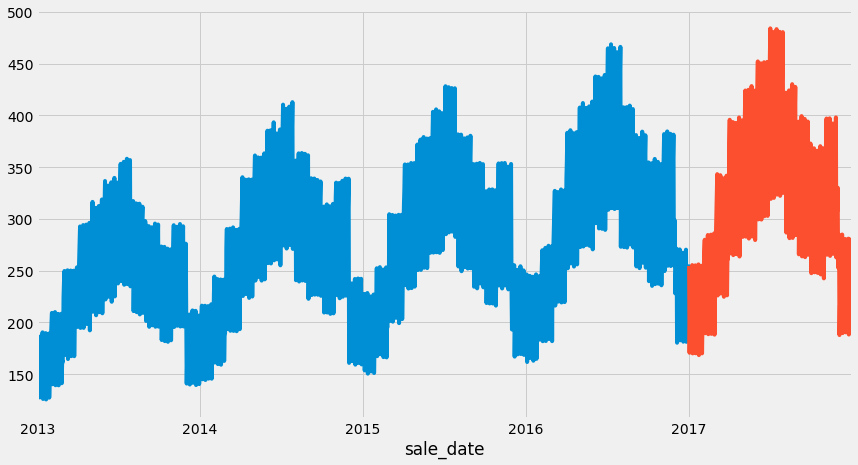

In [6]:
train.resample('D').sales_total.mean().plot()
test.resample('D').sales_total.mean().plot()

> Plot the weekly average & the 7-day moving average. Compare the 2 plots.

In [7]:
y = train.resample('D').sales_total.mean()

Difference between `resample` and `rolling`

In [8]:
y.head(10)

sale_date
2013-01-01 00:00:00+00:00    147.68802
2013-01-02 00:00:00+00:00    147.14116
2013-01-03 00:00:00+00:00    156.33896
2013-01-04 00:00:00+00:00    168.93546
2013-01-05 00:00:00+00:00    175.24370
2013-01-06 00:00:00+00:00    186.18770
2013-01-07 00:00:00+00:00    127.55508
2013-01-08 00:00:00+00:00    145.98932
2013-01-09 00:00:00+00:00    150.26784
2013-01-10 00:00:00+00:00    157.98238
Freq: D, Name: sales_total, dtype: float64

In [9]:
y.head(10).resample('W').mean()

sale_date
2013-01-06 00:00:00+00:00    163.589167
2013-01-13 00:00:00+00:00    145.448655
Freq: W-SUN, Name: sales_total, dtype: float64

In [10]:
y.head(10).rolling(7).mean()

sale_date
2013-01-01 00:00:00+00:00           NaN
2013-01-02 00:00:00+00:00           NaN
2013-01-03 00:00:00+00:00           NaN
2013-01-04 00:00:00+00:00           NaN
2013-01-05 00:00:00+00:00           NaN
2013-01-06 00:00:00+00:00           NaN
2013-01-07 00:00:00+00:00    158.441440
2013-01-08 00:00:00+00:00    158.198769
2013-01-09 00:00:00+00:00    158.645437
2013-01-10 00:00:00+00:00    158.880211
Freq: D, Name: sales_total, dtype: float64

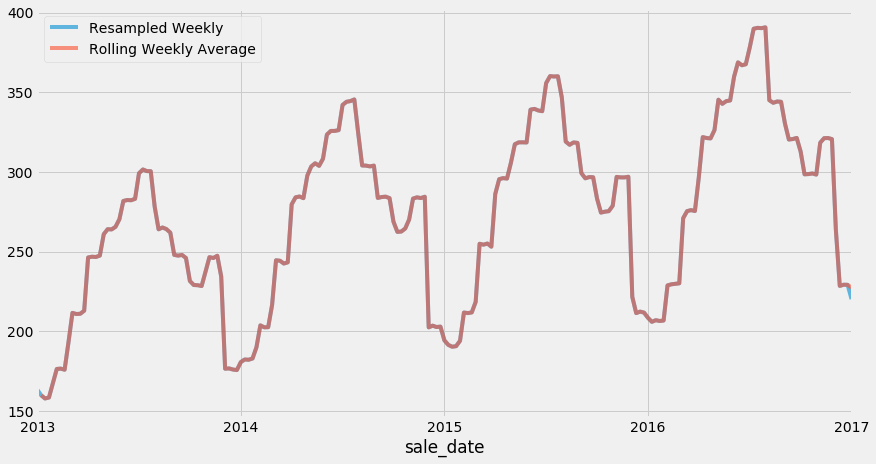

In [11]:
y.resample('W').mean().plot(label='Resampled Weekly', alpha=.6)
y.rolling(7).mean().plot(label='Rolling Weekly Average', alpha=.6)
plt.legend()

Looks like these are about the same.

> Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

Text(0, 0.5, 'Difference in sales from one day to the next')

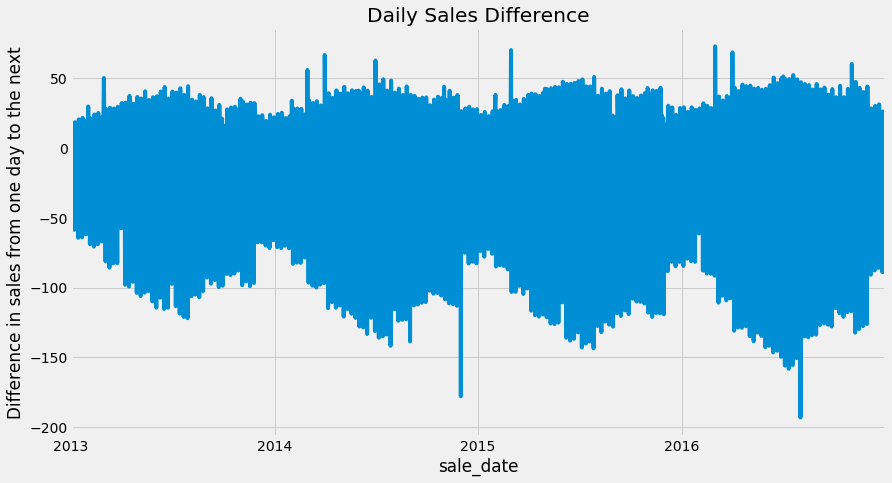

In [12]:
y.diff().plot()
plt.title('Daily Sales Difference')
plt.ylabel('Difference in sales from one day to the next')

Maybe it would be helpful to look at percent change as well:

Percent change is defined as the amount of change as a percentage of the old value.

Text(0, 0.5, '% Change')

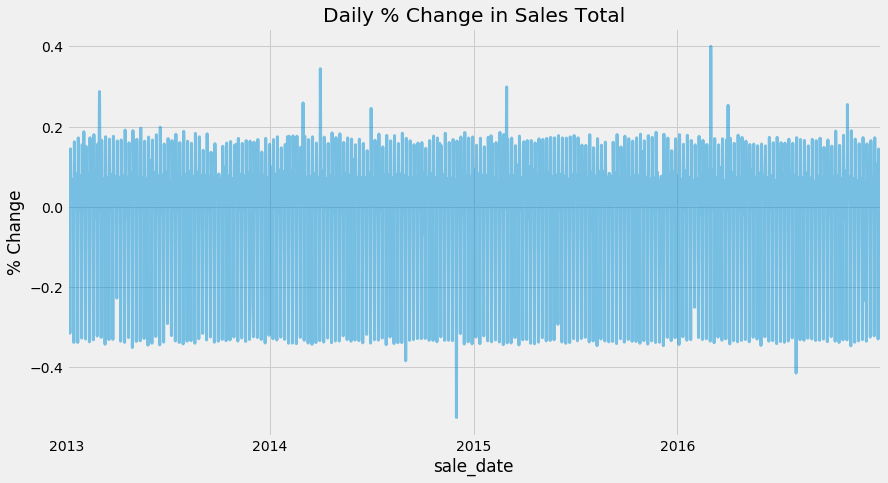

In [13]:
(y.diff() / y.shift()).plot(alpha=.5, lw=3)
plt.title('Daily % Change in Sales Total')
plt.ylabel('% Change')

Let's take a look at this week over week and month over month as well.

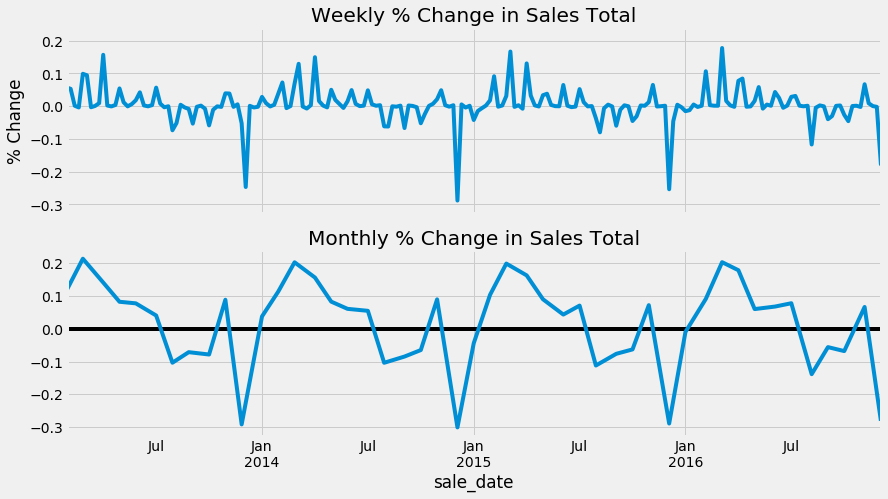

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

weekly = y.resample('W').mean()
(weekly.diff() / weekly.shift()).plot(ax=ax1)
ax1.set(title='Weekly % Change in Sales Total', ylabel='% Change', xlabel='')

monthly = y.resample('M').mean()
(monthly.diff() / monthly.shift()).plot(ax=ax2)
ax2.set(title='Monthly % Change in Sales Total')
ax2.hlines(0, *ax2.get_xlim())

(NB There's also a `pct_change` Series method.)

> Plot a time series decomposition.

In [15]:
y.pct_change()

sale_date
2013-01-01 00:00:00+00:00         NaN
2013-01-02 00:00:00+00:00   -0.003703
2013-01-03 00:00:00+00:00    0.062510
2013-01-04 00:00:00+00:00    0.080572
2013-01-05 00:00:00+00:00    0.037341
                               ...   
2016-12-27 00:00:00+00:00    0.144115
2016-12-28 00:00:00+00:00    0.015976
2016-12-29 00:00:00+00:00    0.075089
2016-12-30 00:00:00+00:00    0.060163
2016-12-31 00:00:00+00:00    0.066445
Freq: D, Name: sales_total, Length: 1461, dtype: float64

In [16]:
sm.__version__

'0.11.0'

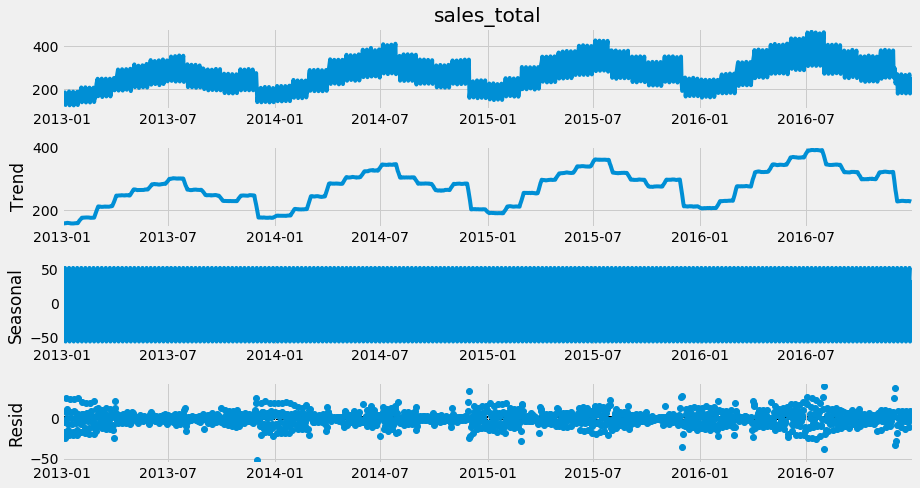

In [17]:
sm.tsa.seasonal_decompose(y).plot()
None

This doesn't look terribly useful, let's try a different frequency.

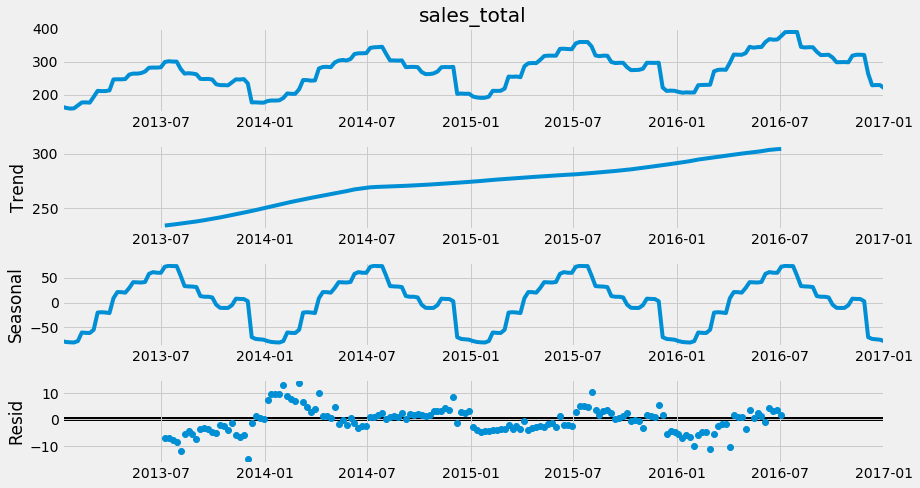

In [18]:
sm.tsa.seasonal_decompose(weekly).plot()
None

> Create a lag plot (day over day).

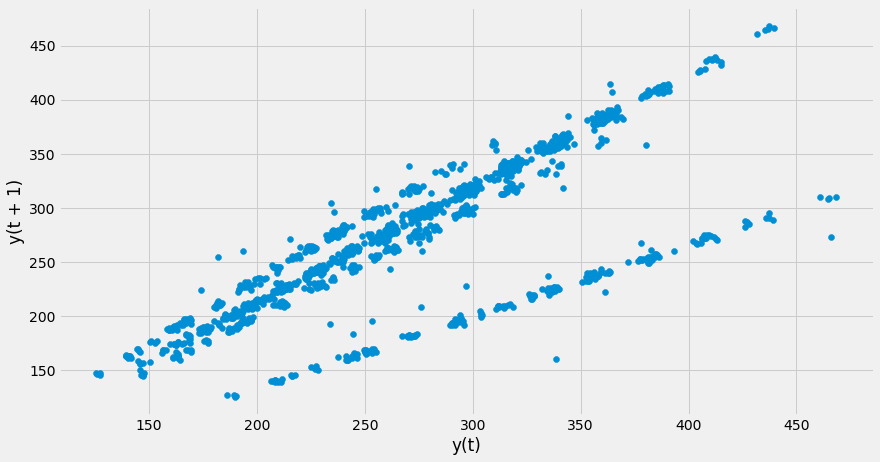

In [19]:
pd.plotting.lag_plot(y)

Let's look at multiple lag periods for the montly data:

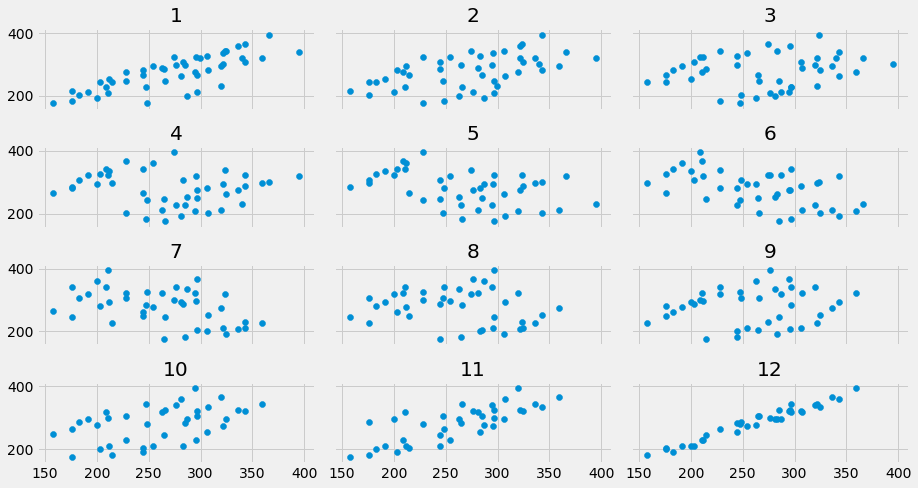

In [20]:
fig, axs = plt.subplots(4, 3, sharex=True, sharey=True)
for ax, lag in zip(axs.ravel(), range(1, 13)):
    pd.plotting.lag_plot(monthly, lag=lag, ax=ax)
    ax.set(title=lag, xlabel='', ylabel='')
fig.tight_layout()

> Run a lag correlation.

In [21]:
pd.DataFrame({
    'y': y,
    'y(t + 1)': y.shift(-1),
    'y(t + 2)': y.shift(-2)
}).corr()

,y,y(t + 1),y(t + 2)
y,1.000000,0.749055,0.666375
y(t + 1),0.749055,1.000000,0.748436
y(t + 2),0.666375,0.748436,1.000000


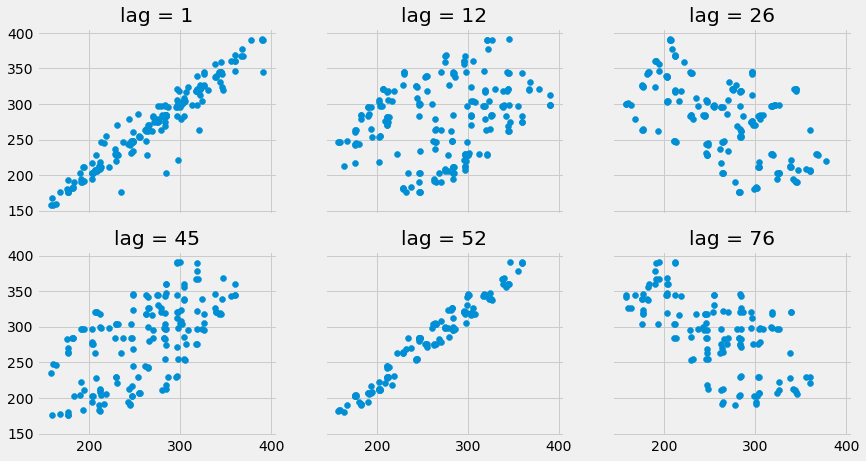

In [22]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True)

for ax, lag in zip(axs.ravel(), [1, 12, 26, 45, 52, 76]):
    pd.plotting.lag_plot(weekly, lag=lag, ax=ax)
    ax.set(title='lag = ' + str(lag), xlabel='', ylabel='')

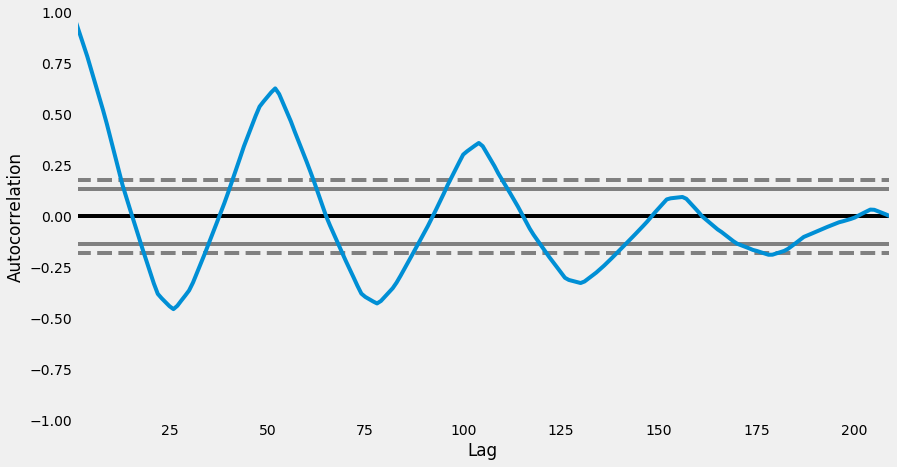

In [23]:
pd.plotting.autocorrelation_plot(weekly)

Text(0.5, 1.0, 'Autocorrelation of Random Noise')

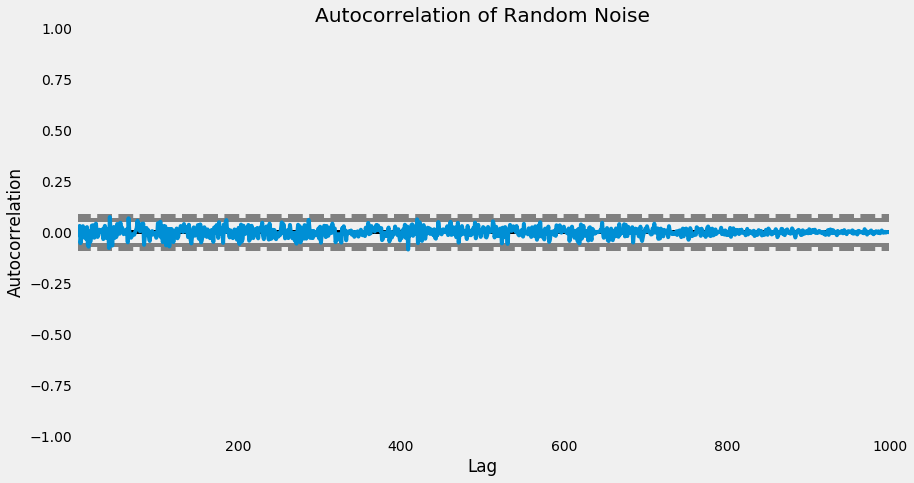

In [24]:
import numpy as np
x = np.random.randn(1000)
pd.plotting.autocorrelation_plot(x)
plt.title('Autocorrelation of Random Noise')

## German Energy Data

In [25]:
df = acquire_walkthrough.german_energy_csv().reset_index()
# .reset_index() so that we can do a percentage based split later
print(df.shape)
df.head()

(4383, 5)


,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


> Split your data into train and test using the percent cutoff method.

In [26]:
train_pct = .8
n = df.shape[0]
test_start_index = round(n * train_pct)

train = df[:test_start_index]
test = df[test_start_index:]

> Validate your splits by plotting X_train and y_train.

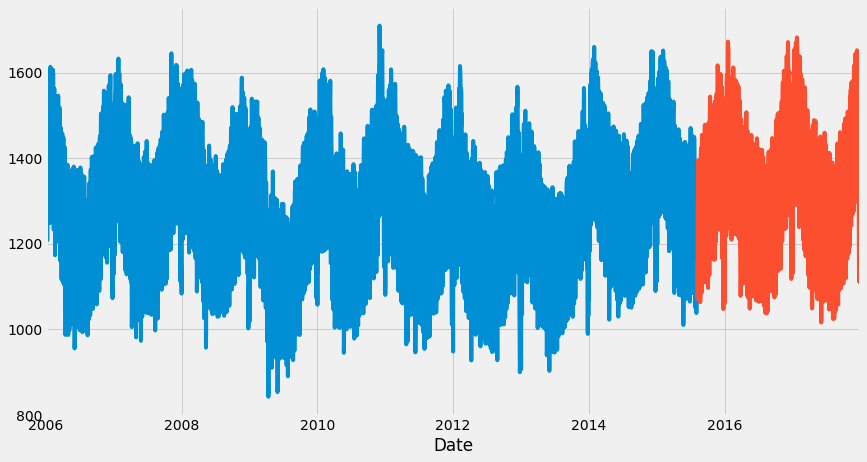

In [27]:
train.set_index('Date').Consumption.plot()
test.set_index('Date').Consumption.plot()

> Plot the weekly average & the 7-day moving average. Compare the 2 plots.

In [28]:
y = train.set_index('Date').Consumption

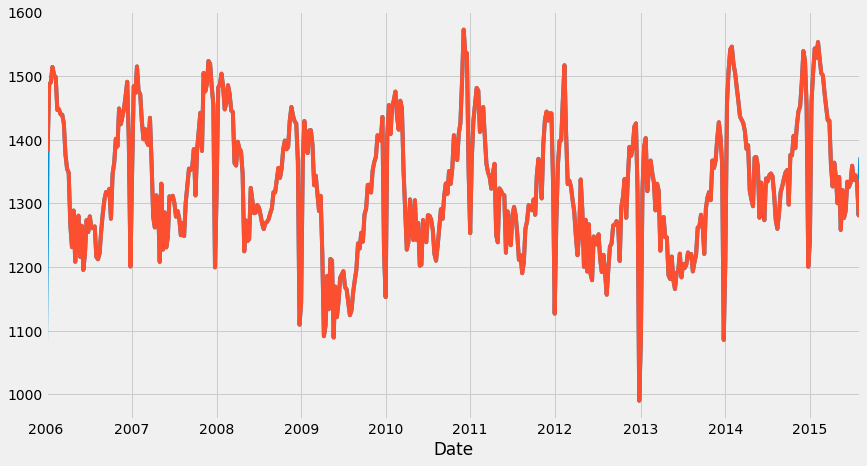

In [29]:
y.resample('W').mean().plot(label='Weekly Average')
y.rolling(7).mean().plot(label='Rolling 7 Day Average')

> Group the electricity consumption time series by month of year, to explore annual seasonality.

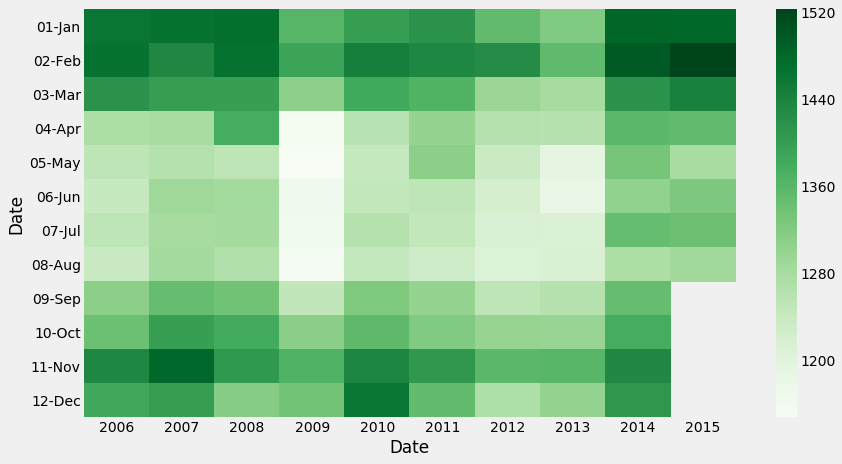

In [30]:
table = y.groupby([y.index.strftime('%Y'), y.index.strftime('%m-%b')]).mean().unstack(0)
sns.heatmap(table, cmap='Greens')

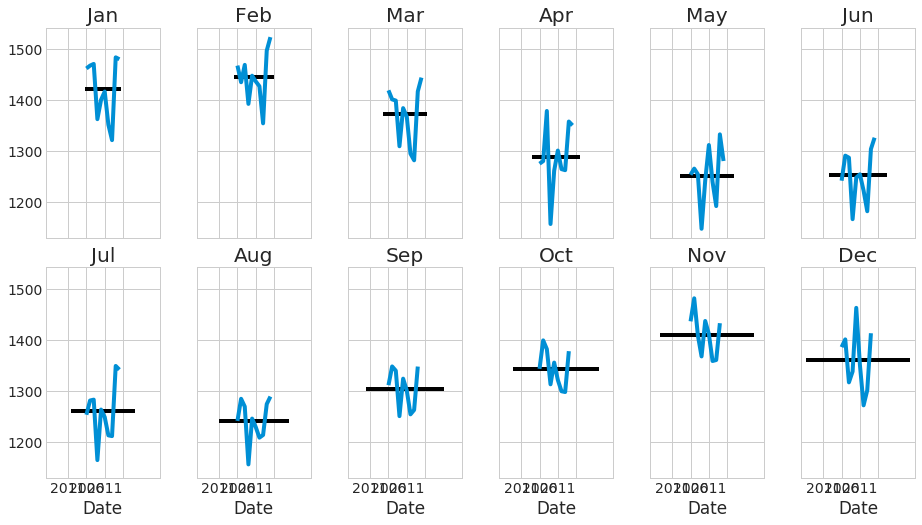

In [31]:
with plt.style.context('seaborn-whitegrid'):
    fig, axs = plt.subplots(2, 6, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)
fig.tight_layout()
for ax, (month, x) in zip(axs.ravel(), table.T.iteritems()):
    x.plot(ax=ax, title=month[3:])
    ax.hlines(x.mean(), *ax.get_xlim())



> Plot the daily difference. Observe whether usage seems to vary drastically from day to day or has more of a smooth transition.

Text(0.5, 1.0, 'Daily % Change in Consumption')

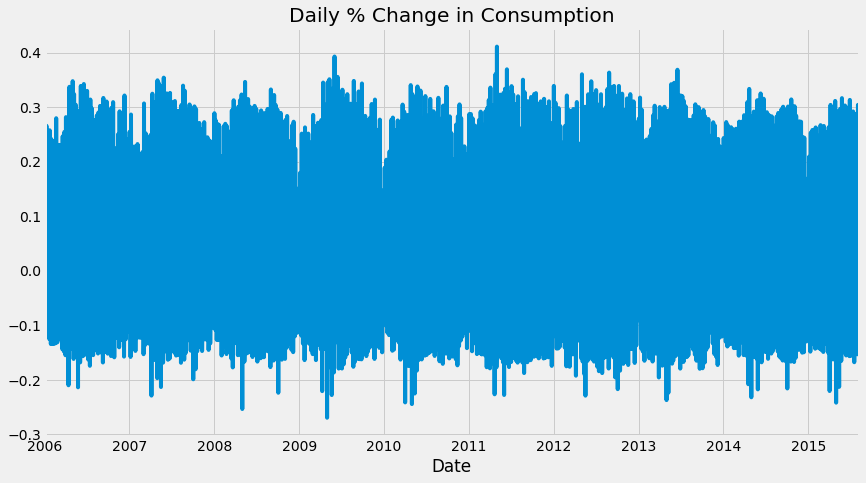

In [32]:
(y.diff() / y.shift()).plot()
plt.title('Daily % Change in Consumption')

> Plot a time series decomposition. Takeaways?

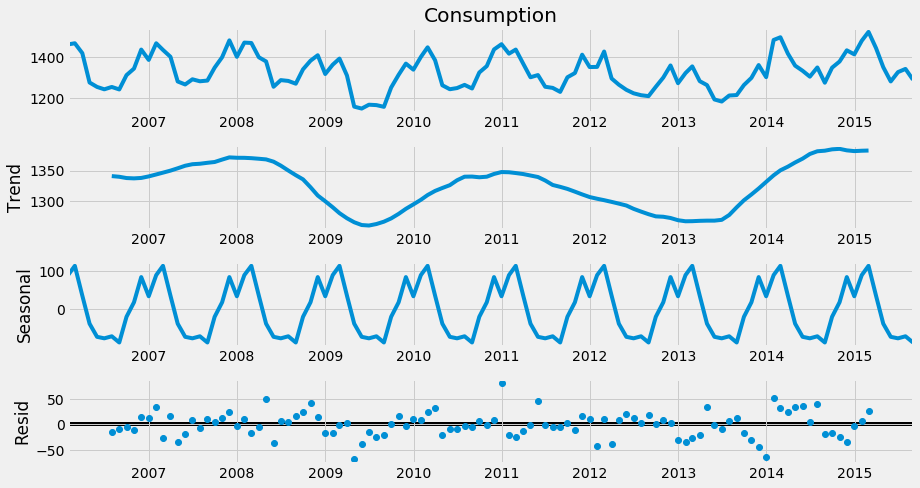

In [33]:
sm.tsa.seasonal_decompose(y.resample('M').mean()).plot()
None

## Bonus

- German Energy Data: show changing source over time
- Store Item Data: visualize different items over time

## Follow up

- on moving averages, check the video posted in the google classroom